In [1]:
import numpy as np
#from sklearn.datasets import fetch_mldata
#from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from scipy.signal import convolve2d, convolve
import torch
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
# from torchvision.datasets import MNIST
# from torchvision import transforms
from IPython.display import clear_output
from typing import Tuple
from tqdm import *
%matplotlib inline

/home/ilya20/documents/MusicTranscription/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
vel = np.array([
    [3, 2, 5, 1],
    [1, 2, 0, 3]
]).astype(float)

pitch = np.array([
    [3, -1, -1, -1],
    [1, 0, -1, -1]
]).astype(float)

# vel[pitch != -1].mean()
# pitch[pitch != -1]
pitch != -1


array([[ True, False, False, False],
       [ True,  True, False, False]])

In [3]:
pred = np.array([
    [0.1, 0.2, 0.5, 0.6],
    [0.25, 0.15, 0.65, 0.6]
])
y = np.array([
    [3, -1, -1, -1],
    [1, 0, -1, -1]
])

def batch_accuracy(X: np.ndarray, y: np.ndarray):
    accuracy = []
    cnt = 0
    success = 0

    X = np.argsort(pred, axis=1)[::, ::-1]
    y_cp = np.copy(y)

    for i in np.arange(X.shape[0]):
        break_point = y_cp[i].tolist().index(-1)
        for j in np.arange(break_point):
            if y_cp[i][j] in X[i][:break_point]:
                success += 1
            cnt += 1
    
    return success / cnt

lst = batch_accuracy(pred, y)
lst

0.3333333333333333

In [4]:
def corrected_f1_score(y_pred: np.ndarray, y_true: np.ndarray) -> float:
    scores = []
    for predict, true in zip(y_pred, y_true):
        pred_size = (predict >= predict[-1]).sum()
        predict = np.argsort(predict)[::-1][:pred_size]

        size = max(pred_size, (true > -1).sum())
        if size > len(predict):
            predict = np.pad(predict, (0, size - len(predict)), constant_values=-1)

        score = f1_score(true[:size], predict, average="macro")
        scores.append(score)
    return sum(scores) / len(scores)

In [5]:
# pred = np.array([
#     np.array([0.1, 0.9, 0.3, 0.8]),
#     np.array([0.0, 0.4, 0.7])
# ])
# y = np.array([
#     np.array([1, 3, -1, -1]),
#     np.array([2, -1, -1, -1]),
# ])
pred = torch.Tensor([
    [0.1, 0.9, 0.3, 0.8],
    [0.1, 0.9, 0.3, 0.4],
])
y = torch.Tensor([
    [1, 3, -1, -1],
    [2, -1, -1, -1],
])

sample = np.array([
    [6, 1, 1, 4],
    [0, 5, 4, 3],
])

corrected_f1_score(pred.data.numpy(), y.data.numpy())

0.5

In [6]:
import matplotlib.pyplot as plt
import note_seq
import bokeh
import librosa.display

from src.features.build_features import detokenize
from src.entities.audio_params import AudioParams
from src.entities.dataset_params import DatasetParams
from src.data.make_dataset import WavMidiDataset, AudioDataset

SAMPLE_RATE = 44100
FRAME_LENGTH = 1000

audio_params = AudioParams(
    sample_rate=SAMPLE_RATE,
    frame_length=FRAME_LENGTH,
    frame_step=FRAME_LENGTH,
    frame_time=FRAME_LENGTH / SAMPLE_RATE,
    n_mels=128,
    fmin=8,
    fmax=12500,
    window="taylor"
)
train_params = DatasetParams(
    root_path="../data/raw/maestro-v3.0.0/",
    metadata="maestro-v3.0.0.csv",
    years_list=[2018],
    split="train",
    audio_params=audio_params,
)

test_params = DatasetParams(
    root_path="../data/raw/maestro-v3.0.0/",
    metadata="maestro-v3.0.0.csv",
    years_list=[2018],
    split="test",
    audio_params=audio_params,
)

/home/ilya20/documents/MusicTranscription/.venv/lib/python3.8/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [7]:
train_ds = WavMidiDataset(train_params)
test_ds = WavMidiDataset(test_params)

In [8]:
len(train_ds), len(test_ds)

(70, 10)

In [15]:
frames, notes, times = train_ds[37]
train_audio_ds = AudioDataset(frames, notes)
train_loader = DataLoader(train_audio_ds, 100)

frames, notes, times = test_ds[7]
test_audio_ds = AudioDataset(frames, notes)
test_loader = DataLoader(test_audio_ds, 100)

In [16]:
# loss = nn.MultiLabelMarginLoss()
# x = torch.FloatTensor([[0.1, 0.9, 0.1, 1]])
# # for target y, only consider labels 3 and 0, not after label -1
# y = torch.LongTensor([[1, 3, -1, -1]])
# # 0.25 * ((1-(0.1-0.2)) + (1-(0.1-0.4)) + (1-(0.8-0.2)) + (1-(0.8-0.4)))
# loss(x, y)

In [17]:
def train(network, epochs: int, learning_rate=1e-4):
    loss_nll = nn.NLLLoss()
    loss_multi = nn.MultiLabelMarginLoss()
    # loss_mse = nn.MSELoss()
    
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    
    try:
        for epoch in range(epochs):

            
            # train
            train_iter = tqdm(train_loader)
            losses_pitch = []
            losses_vel = []
            accuracies_pitch = []
            accuracies_vel = []
            for X, y in train_iter:
                pitch, vel = y
                network.zero_grad()

                # prediction = network.forward(X)
                pred_pitch, pred_vel = network.forward(X)

                loss_batch_pitch = loss_multi(pred_pitch, pitch)
                losses_pitch.append(loss_batch_pitch.item())
                loss_batch_pitch.backward()

                train_iter.set_description("Epoch: %04d, Iter Loss: %.4f"  %(epoch, loss_batch_pitch))

                # loss_batch_vel = loss_nll(pred_vel, y[1])
                # losses_vel.append(loss_batch_vel.item())
                # loss_batch_vel.backward()

                optimizer.step()
                accuracies_pitch.append(corrected_f1_score(pred_pitch.detach().numpy(), pitch.detach().numpy()))
                # accuracies_pitch.append(losses_pitch[-1])
                # left count vel
                # accuracies_vel.append()

            train_loss_epochs.append(np.mean(losses_pitch))
            train_accuracy_epochs.append(np.mean(accuracies_pitch))

            # test
            losses = []
            accuracies = []
            for X, y in test_loader:
                pitch, vel = y

                # prediction = network.forward(X)
                pred_pitch, pred_vel = network.forward(X)

                loss_batch = loss_multi(pred_pitch, pitch)
                losses.append(loss_batch.item())

                accuracies.append(corrected_f1_score(pred_pitch.detach().numpy(), pitch.detach().numpy()))
                # accuracies.append(losses[-1])

            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            
            # output
            clear_output(True)
            print('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(test_loss_epochs, label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.subplot(1, 2, 2)
            plt.plot(train_accuracy_epochs, label='Train accuracy')
            plt.plot(test_accuracy_epochs, label='Test accuracy')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        pass

In [18]:
class DummyNet(nn.Module):
    def __init__(self, frame_size: int) -> None:
        super().__init__()

        self.linear_layers = nn.Sequential(
            nn.Linear(frame_size, frame_size * 2),
            nn.Dropout(0.3),
            nn.ReLU(),
            # nn.Linear(frame_size * 4, frame_size * 2),
            # nn.Dropout(0.3),
            # nn.ReLU(),
            nn.Linear(frame_size * 2, 129),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.linear_layers(x)
        return x, 90

Epoch 3... (Train/Test) NLL: 0.363/1.630	Accuracy: 0.046/0.027


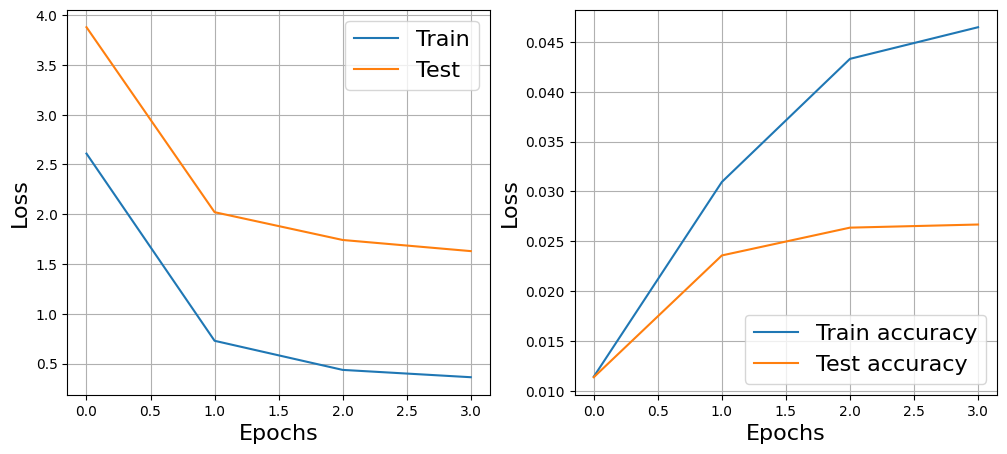

Epoch: 0004, Iter Loss: 0.2575:  78%|███████▊  | 377/482 [00:21<00:05, 17.80it/s]


In [19]:
net = DummyNet(128)
train(net, 10, 1e-4)

In [27]:
frames, notes, times = train_ds[37]
midi_filename, _ = train_ds._data.iloc[37]
ns = note_seq.midi_file_to_note_sequence(train_ds._root_path + midi_filename)

In [28]:
frames.shape

(128, 48188)

In [29]:
frames_reshaped = torch.Tensor(frames.reshape(-1, 128))

In [30]:
frames_reshaped.shape

torch.Size([48188, 128])

In [31]:
pred_pitch, pred_vel = net.forward(frames_reshaped)

In [32]:
notes[0]

(array([128,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
         -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
         -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
         -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
         -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
         -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
         -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
         -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
         -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
         -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [33]:
pred_pitch.shape

torch.Size([48188, 129])

In [34]:
def decode_predict(pitches, vels):
    notes = []
    pitches = pitches.detach()
    softmax = nn.Softmax(dim=1)
    pitches = softmax(pitches).numpy()
    for pitch in pitches:
        pred_size = (pitch >= pitch[128]).sum()
        # pred_size = 5
        pitch = np.argsort(pitch)[::-1][:pred_size]
        vel = np.full_like(pitch, vels)

        notes.append((pitch, vel))
    return notes

In [35]:
pred_notes = decode_predict(pred_pitch, pred_vel)

In [36]:
pred_notes[200]

(array([ 81, 128]), array([90, 90]))

In [37]:
import bokeh

fig = note_seq.plot_sequence(ns, False)
fig_proc = note_seq.plot_sequence(detokenize(pred_notes, times, audio_params.frame_time), False)

fig.height = 500
fig_proc.height = 500
fig.width = 1500
fig_proc.width = 1500

bokeh.plotting.output_notebook()
bokeh.plotting.show(fig)
bokeh.plotting.show(fig_proc)

Loading BokehJS ...

### Conv2D

In [5]:
#constants
image_size = (28, 28)
conv1 = 32
conv2 = 64

# conv_nn
class ConvTwoD(nn.Module):
    def __init__(self, image_size: Tuple[int, int],
        conv1=conv1, conv2=conv2
    ):
        super(ConvTwoD, self).__init__()
        self.conv_layers1 = nn.Sequential(
            nn.Conv2d(1, conv1, kernel_size=(5,5), stride=(1,1)),
            nn.Tanh(),
            nn.Dropout(0.5),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        )
        
        self.conv_layers2 = nn.Sequential(
            nn.Conv2d(conv1, conv2, kernel_size=(3,3), stride=(2,2)),
            nn.Tanh(),
            nn.Dropout(0.5),
            nn.MaxPool2d(kernel_size=(2,2))
        )
        
        self.linear_velocity = nn.Sequential(
            nn.Linear(
                conv2 * image_size[0]//2 * image_size[1]//2,
                128
            ),
            nn.LogSoftmax(dim=1)
        )

        self.linear_pitch = nn.Sequential(
            nn.Linear(
                conv2 * image_size[0]//2 * image_size[1]//2,
                128
            ),
            nn.LogSoftmax(dim=1)
        )
    
    def forward(self, x):
#         print("======")
#         print(x.shape)
        x = self.conv_layers1(x)
#         print(x.shape)
        x = self.conv_layers2(x)
#         print(x.shape)
        x = x.view(x.size(0), -1)
#         print(x.shape)
        pitch = self.linear_pitch(x)
        velocity = self.linear_velocity(x)
        
        return pitch, velocity

### Conv1D

In [6]:
#constants
image_size = 28
conv1 = 32
conv2 = 64

# conv_nn
class ConvOneD(nn.Module):
    def __init__(self, image_size: Tuple[int, int],
        conv1=conv1, conv2=conv2
    ):
        super(ConvOneD, self).__init__()
        self.conv_layers1 = nn.Sequential(
            # nn.Conv2d(1, conv1, kernel_size=(5,5), stride=(1,1)),
            nn.Tanh(),
            nn.Dropout(0.5),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.conv_layers2 = nn.Sequential(
            # nn.Conv2d(conv1, conv2, kernel_size=(3,3), stride=(2,2)),
            nn.Tanh(),
            nn.Dropout(0.5),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.linear_velocity = nn.Sequential(
            nn.Linear(
                conv2 * image_size,
                128
            ),
            nn.LogSoftmax(dim=1)
        )

        self.linear_pitch = nn.Sequential(
            nn.Linear(
                conv2 * image_size,
                128
            ),
            nn.LogSoftmax(dim=1)
        )
    
    def forward(self, x):
#         print("======")
#         print(x.shape)
        x = convolve(x, 5, mode="same")
        x = self.conv_layers1(x)
#         print(x.shape)
        x = convolve(x, 5, mode="same")
        # x = self.conv_layers2(x)
#         print(x.shape)
        x = x.view(x.size(0), -1)
#         print(x.shape)
        pitch = self.linear_pitch(x)
        velocity = self.linear_velocity(x)
        
        return pitch, velocity

In [ ]:
network1 = Conv(image_size=image_size)
train(network1, 5)